In [1]:
import sys
print(sys.executable)
!{sys.executable} pip uninstall awswrangler -y
!{sys.executable} -m pip install awswrangler

/opt/homebrew/Cellar/jupyterlab/4.3.4/libexec/bin/python
/opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/Resources/Python.app/Contents/MacOS/Python: can't open file '/Users/shrishaila.b/Documents/ML_Analysis/pip': [Errno 2] No such file or directory

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.3.4/libexec/bin/python -m pip install --upgrade pip


In [2]:
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install awswrangler


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.3.4/libexec/bin/python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.3.4/libexec/bin/python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.3.4/libexec/bin/python -m pip install --upgrade pip


In [3]:
import awswrangler as wr
import pandas as pd
import boto3
from io import StringIO, BytesIO
import os
import sys

os.environ['AWS_ACCESS_KEY_ID'] = '*'
os.environ['AWS_SECRET_ACCESS_KEY'] = '**'

df = wr.s3.read_parquet('s3://bucket/dev/users/shri/snow_id_test/')

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [37]:
y_samples = df[df['is_test_device'] == 'Y'].sample(n=5000, random_state=42)

# Sample 20,000 rows where is_test_device = 'N' 
n_samples = df[df['is_test_device'] == 'N'].sample(n=20000, random_state=42)

# Combine into final balanced DataFrame
filteredf = pd.concat([y_samples, n_samples])

# Verify
print(filteredf['is_test_device'].value_counts())


#filteredf = df.sample(frac=0.1, random_state=42)
#filteredf = df.groupby('is_test_device', group_keys=False).apply(lambda x: x.sample(frac=0.1, random_state=42))

df_selected_cols = filteredf[['hsn', 'country', 'mso']]
df_selected_cols.loc[:, 'hsn'] = df_selected_cols['hsn'].fillna('Unknown')
df_selected_cols.loc[:, 'country'] = df_selected_cols['country'].fillna('Unknown')
df_selected_cols.loc[:, 'mso'] = df_selected_cols['mso'].fillna('Unknown')

#df_selected_cols.head()


<StringArray>
['Y']
Length: 1, dtype: string
is_test_device
N    20000
Y     5000
Name: count, dtype: Int64


In [18]:

filteredf_y = filteredf[(filteredf['is_test_device'] == 'Y')][['hsn', 'mso', 'country', 'is_test_device']]
#print(filteredf_y.head(200))
#print(filteredf['is_test_device'].unique())


In [19]:
combined = [
    f"{hn} {country} {oss}" 
    for hn, country, oss in zip(
        df_selected_cols['hsn'].values, 
        df_selected_cols['country'].values, 
        df_selected_cols['mso'].values
    )
]
df_selected_cols['combined_independant_features'] = combined

cv = CountVectorizer(ngram_range= (1,1), max_features=None, binary =True)
vectorized = cv.fit_transform(df_selected_cols['combined_independant_features'])

#print(vectorized.shape)
#print(vectorized.toarray())
combined_independant_features_df = pd.DataFrame(vectorized.toarray(), columns=cv.get_feature_names_out())

print(combined_independant_features_df.shape)
#print(combined_independant_features_df)

(25000, 20150)


/var/folders/ky/t8dn369j6bn20z5mpqxjky540000gq/T/ipykernel_26724/623513337.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_cols['combined_independant_features'] = combined


In [56]:

label_encoder = LabelEncoder()
print("label_encoder: ", label_encoder)
#print(df['is_test_device'])
y = label_encoder.fit_transform(filteredf['is_test_device'])
print(y.shape)


label_encoder:  LabelEncoder()
(25000,)


In [21]:

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_independant_features_df, y, test_size=0.2, stratify=y)

In [22]:


print("X_train.shape: ", X_train.shape, "X_test.shape: ", X_test.shape)
print("y_train.shape: ", y_train.shape, "y_test.shape: ", y_test.shape)

NB_model = MultinomialNB()
try:
    NB_model.fit(X_train, y_train)
    y_pred = NB_model.predict(X_test)
    print("Prediction successful!")
except Exception as e:
    print("An error occurred:", e)

X_train.shape:  (20000, 20150) X_test.shape:  (5000, 20150)
y_train.shape:  (20000,) y_test.shape:  (5000,)
Prediction successful!


{'N': np.int64(0), 'Y': np.int64(1)}
Accuracy: 0.941


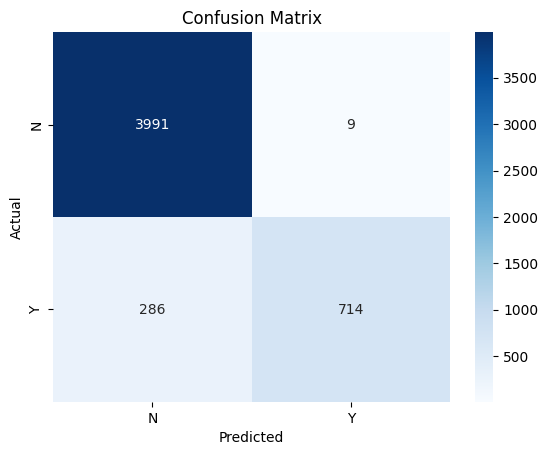

In [57]:
class_names = label_encoder.classes_
print(dict(zip(label_encoder.classes_, label_encoder.transform(class_names))))
print("Accuracy:", accuracy_score(y_test, y_pred))
#print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [24]:

test_example = {
    'hsn': '****',
    'country': 'USA',
    'mso': 'bmw'
}


test_example_processed = (
    str(test_example['hsn']) + ' ' + 
    str(test_example['country']) + ' ' + 
    str(test_example['mso'])
)

X_test_example = cv.transform([test_example_processed])  # Note the list wrapper

prediction = NB_model.predict(X_test_example)

predicted_label = label_encoder.inverse_transform(prediction)[0]

print(f"Predicted class: {predicted_label}")


Predicted class: N


/opt/homebrew/Cellar/jupyterlab/4.3.4/libexec/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


In [47]:

test_example = {
    'hsn': 'V***',
    'country': 'DEU',
    'mso': 'FFF'
}


test_example_processed = (
    str(test_example['hsn']) + ' ' + 
    str(test_example['country']) + ' ' + 
    str(test_example['mso'])
)

X_test_example = cv.transform([test_example_processed])  # Note the list wrapper

prediction = NB_model.predict(X_test_example)

predicted_label = label_encoder.inverse_transform(prediction)[0]

print(f"Predicted class: {predicted_label}")


Predicted class: Y


/opt/homebrew/Cellar/jupyterlab/4.3.4/libexec/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


In [ ]:
chkdf_n = df[(df['hsn'] == '%^%')& (df['country'] == 'USA')][['hsn', 'mso', 'country', 'is_test_device']]
print(chkdf_n)

chkdf_y = df[(df['hsn'] == '&&^&&&')& (df['country'] == 'DEU')][['hsn', 'mso', 'country', 'is_test_device']].drop_duplicates()
print(chkdf_y)

chkdf_yy = df[(df['is_test_device'] == 'Y')][['hsn', 'mso', 'country', 'is_test_device']].drop_duplicates()
print(chkdf_yy)

file_path = "/Users/shrishaila.b/Downloads/hsn_used_for_train1.csv"
chkdf_yy.to_csv(file_path, index=False)

"""
chkdf_y = df[(df['is_test_device'] == 'Y')][['hsn', 'mso', 'country', 'is_test_device']]
print(chkdf_y)
"""


In [ ]:
#test

import numpy as np

# Convert encoded y_test and y_pred back to original labels ('N'/'Y')
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred)

# Find indices where actual = 'N' but predicted = 'Y'
false_positives_mask = (y_test_original == 'N') & (y_pred_original == 'Y')
false_positive_indices = np.where(false_positives_mask)[0]  # Gets the positions in y_test/y_pred


# Get the original DataFrame indices (since X_test retains them)
original_indices = X_test.index[false_positive_indices]

# Extract the relevant rows
false_positive_data = df_selected_cols.loc[original_indices].copy()

# Add predictions for context
false_positive_data['Actual'] = 'N'
false_positive_data['Predicted'] = 'Y'

print("false_positive_data: ", false_positive_data)



# Display key columns
print(false_positive_data[[ 'Actual', 'Predicted']].head())

# Save to CSV if needed
#false_positive_data.to_csv('false_positives.csv', index=False)

In [ ]:

chkdf_y = df[(df['hsn'] == 'UUUUUU')& (df['country'] == 'TUR')][['hsn', 'mso', 'country', 'is_test_device']].drop_duplicates()
print(chkdf_y)

In [68]:

test_example = {
    'hsn': 'UYYTYY',
    'country': 'TUR',
    'mso': 'vestel'
}


test_example_processed = (
    str(test_example['hsn']) + ' ' + 
    str(test_example['country']) + ' ' + 
    str(test_example['mso'])
)

X_test_example = cv.transform([test_example_processed])  # Note the list wrapper

prediction = NB_model.predict(X_test_example)

predicted_label = label_encoder.inverse_transform(prediction)[0]

print(f"Predicted class: {predicted_label}")


Predicted class: Y


/opt/homebrew/Cellar/jupyterlab/4.3.4/libexec/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(
